In [ ]:
#Connect Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive/')

project_folder = "/content/drive/My Drive/Colab/"

In [ ]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# visualize missing values
import missingno as msno

# model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# linear classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# non-linear classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# ensemble learners
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# model persistence
from pickle import dump
from pickle import load

# ignore deprecated warnings
import warnings
warnings.filterwarnings('ignore')

In [23]:
project_folder = "."

<a href="https://colab.research.google.com/github/cmadding/MSDS_7333_QTW/blob/master/Case_Study_Unit_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Case Study Unit 15  

Allen Ansari, Chris Ballenger, Shantanu Godbole, Chad Madding

DS 7333 Quantifying the World

August 15, 2020

#### Introduction
In this unit, we will be using an ensemble of categorical prediction methods to find the best accuracy and ROC score. A gridsearch will assist in removing low performing features from random forest and keep the optimal features. We will focus on metrics like the F1-Score, accuracy, recall, precision, and the ROC score to find the best prediction rate while finding the best balance between true positives and false negatives.

#### Methods
In this project, we will first work on data exploration, any needed categorical data conversion, and replacing missing values.
After exploration and cleaning, we will look at the best categorical predictors while removing lesser features. We will perform a gridsearch to assist with hyperparameter tuning for our random forest parameters. Finally, we will design an ensemble model with the highest ROC score, accuracy, precision, recall, and F1-Score.

In [3]:
import pandas as pd
import os
# read in the dataset
data = pd.read_csv(os.path.join(project_folder,"data",'final_project.csv'))
data.shape

(160000, 51)

The dataset contains 50 variables and 160,000 rows of data.  The last variable `y` is the response variable.

We can look at the first few rows of data to see the makeup of the dataset.

In [4]:
#the first five rows of data
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,6.718751,-14.789997,-1.040673,-4.204950,...,-1.497117,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,40.477058,-6.725709,0.896421,0.330165,...,36.292790,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974,0
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,17.812850,11.060572,5.325880,-2.632984,...,-0.368491,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-35.111751,-18.913592,-0.337041,-5.568076,...,15.691546,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847,0
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,-16.505817,27.532281,1.199715,-4.309105,...,-13.911297,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1


In [5]:
print("Table 1: Basic Statistical Details")
data.describe()

Table 1: Basic Statistical Details


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
count,159974.000000,159975.000000,159962.000000,159963.000000,159974.000000,159963.000000,159974.000000,159973.000000,159979.000000,159970.000000,...,159960.000000,159974.000000,159963.000000,159960.000000,159971.000000,159969.000000,159963.000000,159968.000000,159968.000000,160000.000000
mean,-0.001028,0.001358,-1.150145,-0.024637,-0.000549,0.013582,-1.670670,-7.692795,-0.030540,0.005462,...,6.701076,-1.833820,-0.002091,-0.006250,0.000885,-12.755395,0.028622,-0.000224,-0.674224,0.401231
std,0.371137,6.340632,13.273480,8.065032,6.382293,7.670076,19.298665,30.542264,8.901185,6.355040,...,18.680196,5.110705,1.534952,4.164595,0.396621,36.608641,4.788157,1.935501,15.036738,0.490149
min,-1.592635,-26.278302,-59.394048,-35.476594,-28.467536,-33.822988,-86.354483,-181.506976,-37.691045,-27.980659,...,-82.167224,-27.933750,-6.876234,-17.983487,-1.753221,-201.826828,-21.086333,-8.490155,-65.791191,0.000000
25%,-0.251641,-4.260973,-10.166536,-5.454438,-4.313118,-5.148130,-14.780146,-27.324771,-6.031058,-4.260619,...,-5.804080,-5.162869,-1.039677,-2.812055,-0.266518,-36.428329,-3.216016,-1.320800,-10.931753,0.000000
50%,-0.002047,0.004813,-1.340932,-0.031408,0.000857,0.014118,-1.948594,-6.956789,-0.016840,0.006045,...,6.840110,-1.923754,-0.004385,-0.010484,0.001645,-12.982497,0.035865,-0.011993,-0.574410,0.000000
75%,0.248532,4.284220,7.871676,5.445179,4.306660,5.190749,11.446931,12.217071,5.972349,4.305734,...,19.266367,1.453507,1.033275,2.783274,0.269049,11.445443,3.268028,1.317703,9.651072,1.000000
max,1.600849,27.988178,63.545653,38.906025,26.247812,35.550110,92.390605,149.150634,39.049831,27.377842,...,100.050432,22.668041,6.680922,19.069759,1.669205,150.859415,20.836854,8.226552,66.877604,1.000000


In [6]:
display(data.describe(include=['object']))
print("Table 2: Categorical Details")

,x24,x29,x30,x32,x37
count,159972,159970,159970,159969,159977
unique,3,12,5,12,129198
top,asia,July,wednesday,0.01%,$-415.46
freq,138965,45569,101535,40767,6


Table 2: Categorical Details


There are a few categorical varables that will need encoding. x 32 and x37 look to not be encoded correctley. x32 has a % sigh and x37 has a dollar amount. We can remove the $ sign and the % sigh then conver them to a float value.

In [7]:
# x32 has a % that needs to be removed and convert to float
def PerSign(var):
    var = var.str.replace('%', "")
    return var.astype("float")

data['x32'] = PerSign(data['x32'])
data.x32.head()

0    0.00
1   -0.02
2   -0.01
3    0.01
4    0.01
Name: x32, dtype: float64

In [8]:
# x37 has a $ that needs to be removed and convert to float
def DollarSign(var):
    var = var.str.replace('$', "")
    return var.astype("float")

data['x37'] = DollarSign(data['x37'])
data.x37.head()

0    1313.96
1    1962.78
2     430.47
3   -2366.29
4    -620.66
Name: x37, dtype: float64

There are only three catagorital variables left. With entries like asia, July and wednesday, these look to be variables we can encode propertaly.

In [9]:
# count the 'opjects'
data.loc[:,data.dtypes == "object"].describe().T

,count,unique,top,freq
x24,159972,3,asia,138965
x29,159970,12,July,45569
x30,159970,5,wednesday,101535


### Finding low unique values

In [10]:
uniques = {}

for col in data.columns:
    uniques[col] = (data.dtypes[col], len(data[col].value_counts()))

for key, val in uniques.items():
    if (val[1] / len(data)) < .2:
        print(key, val)

x24 (dtype('O'), 3)
x29 (dtype('O'), 12)
x30 (dtype('O'), 5)
x32 (dtype('float64'), 11)
y (dtype('int64'), 2)


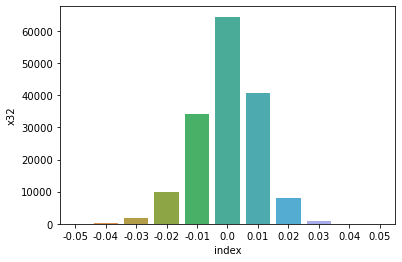

Fig 1: Count of each value in Column x32


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

df = data["x32"].value_counts().reset_index()

ax = sns.barplot(x="index", y="x32", data=df)
plt.show()
print("Fig 1: Count of each value in Column x32")

We will leave `x32` as numeric.

## Some Exploratory Data Analysis

Some of the values are highly correlated, we should remove some of them!

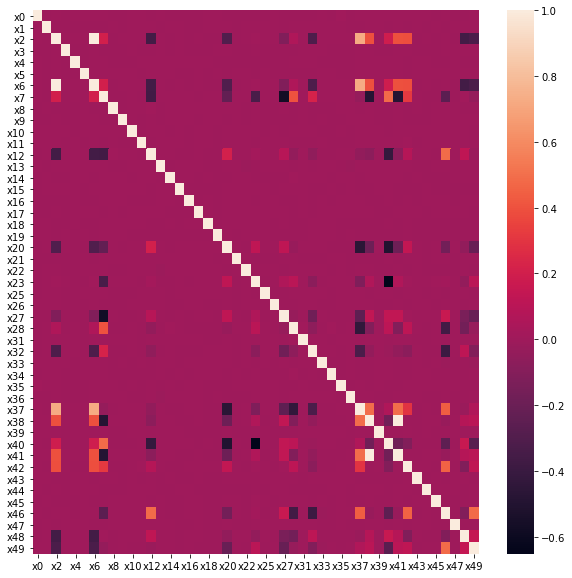

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = data.dtypes
del columns["y"]
cols_obj = columns[columns==object].index
cols_flt = columns[columns!=object].index

idx = (data.isna().sum(axis=1) == 0)

corr = data.loc[idx,cols_flt].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,ax=ax)
plt.show()

In [14]:
data_reduced = reduce_features(data, True)

There are  2  field correlations > 95%.


,drop,keep,Correlation
0,x6,x2,1.0
1,x41,x38,1.0


Dropping the following  2  highly correlated fields.

*********Before: Dropping Highly Correlated Fields*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Columns: 51 entries, x0 to y
dtypes: float64(47), int64(1), object(3)
memory usage: 62.3+ MB


None


*********After: Dropping Highly Correlated Fields**************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Columns: 49 entries, x0 to y
dtypes: float64(45), int64(1), object(3)
memory usage: 59.8+ MB


Review histogram and other correlations to Y

# CHAD PUT HIST THERE

## Let's review Imputation

But first, we need to create a hold-out set that will not be included for imputaiton.  The impututaiton of this data will be based on the training data.

In [12]:
# # divide the variables based on their types
# objects = data.loc[:, data.dtypes == object]
# numerics = data.loc[:, data.dtypes != object]
# responseVariable = data.y

In [15]:
from sklearn.model_selection import train_test_split

columns = data_reduced.dtypes
del columns["y"]

data_train, data_test, y_train, y_test = train_test_split(
    data_reduced.iloc[:,:-1], data_reduced.iloc[:,-1], 
    test_size=0.20, random_state=76244
)

**Catagorical Imputation**

Rows with missing values catagorical values will be marked `str("NA")` in order to include model these values.

In [16]:
print(data_train.loc[:,data_train.dtypes==object].isna().sum(axis=0))
print("Table 3: Count of rows for each column with missing values")

x24    21
x29    21
x30    25
dtype: int64
Table 3: Count of rows for each column with missing values


In [17]:
cols_obj = columns[columns==object].index
cols_flt = columns[columns!=object].index

data_train[cols_obj] = data_train[cols_obj].fillna(str("NA"))
data_test[cols_obj] = data_test[cols_obj].fillna(str("NA"))

print(data_train.loc[:,data_train.dtypes==object].isna().sum(axis=0))
print("Table 4: Output after updating NA")

x24    0
x29    0
x30    0
dtype: int64
Table 4: Output after updating NA


**Numeric Imputation**

We opted to use `KNNImputer` to impute our results.  First thing we did was identify the optimal number of`n_neighbors`. Using 

In [18]:
from sklearn.impute import KNNImputer
import pickle

try:
    with open(os.path.join(project_folder,"models","imputer.pkl"),"rb") as f:
        imputer = pickle.load(f)
except:
    print("Model does not exist, fitting model")
    k = int(len(data_train)**(1/2))
    imputer = KNNImputer(n_neighbors=k)
    imputer.fit(data_train[cols_flt.values])
    with open(os.path.join(project_folder,"models","imputer.pkl"),"wb") as f:
        pickle.dump(imputer, f)

X_train_flt = imputer.transform(data_train[cols_flt].values)
X_test_flt = imputer.transform(data_test[cols_flt].values)

print("X_train_flt",X_train_flt.shape)
print("X_test_flt",X_test_flt.shape)

X_train_flt (128000, 45)
X_test_flt (32000, 45)


**One Hot Encoding Features**

In [19]:
from sklearn.preprocessing import OneHotEncoder

try:
    with open(os.path.join(project_folder,"models","encoder.pkl"),"rb") as f:
        encoder = pickle.load(f)
except:
    print("Model does not exist, fitting model")
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(data_train[cols_obj].values)
    with open(os.path.join(project_folder,"models","encoder.pkl"),"wb") as f:
        pickle.dump(encoder, f)

X_train_obj = encoder.transform(data_train[cols_obj].values)
X_test_obj = encoder.transform(data_test[cols_obj].values)

print("X_train_obj",X_train_obj.shape)
print("X_test_obj",X_test_obj.shape)

Model does not exist, fitting model
X_train_obj (128000, 23)
X_test_obj (32000, 23)


In [20]:
# Quick Example how to see the data
pd.DataFrame(X_train_obj.toarray(),columns=encoder.get_feature_names(cols_obj))

,x24_NA,x24_america,x24_asia,x24_euorpe,x29_Apr,x29_Aug,x29_Dev,x29_Feb,x29_January,x29_July,...,x29_NA,x29_Nov,x29_Oct,x29_sept.,x30_NA,x30_friday,x30_monday,x30_thurday,x30_tuesday,x30_wednesday
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
127996,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
127997,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
127998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**Create our final Train & Test Set**

In [21]:
from scipy.sparse import hstack
import pickle

X_train = hstack([X_train_flt, X_train_obj])
X_test = hstack([X_test_flt, X_test_obj])

print("X_train",X_train.shape)
print("X_test",X_test.shape)

with open(os.path.join(project_folder,"data","train_test.pkl"), "wb") as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

X_train (128000, 68)
X_test (32000, 68)


In [25]:
import pickle

with open(os.path.join(project_folder,"data","train_test.pkl"), "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)
    
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (128000, 68)
y_train (128000,)
X_test (32000, 68)
y_test (32000,)


# MODELING!

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=76244, n_jobs=-2)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-2, random_state=76244)

| Confusion Matrix | |
| :---: | :---: |
| True Negative (\$0)    | False Positive (\$10) |
| False Negative (\$500) | True Positve (\$0) |

\begin{equation*}
Precision = \frac{tp}{tp + fp}
\end{equation*}



\begin{equation*}
Recall = \frac{tp}{tp + fn}
\end{equation*}

In [31]:
from sklearn import metrics

y_hat = rf_clf.predict(X_test)
y_hat_proba = rf_clf.predict_proba(X_test)

print( metrics.confusion_matrix(y_test, y_hat) )
print( metrics.classification_report(y_test, y_hat) )

[[18395   839]
 [ 1671 11095]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     19234
           1       0.93      0.87      0.90     12766

    accuracy                           0.92     32000
   macro avg       0.92      0.91      0.92     32000
weighted avg       0.92      0.92      0.92     32000



In [50]:
print("False Negative:", metrics.confusion_matrix(y_test, y_hat)[1,0] * 500)
print("False Positive:", metrics.confusion_matrix(y_test, y_hat)[0,1] * 10)

False Negative: 835500
False Positive: 8390


In [49]:
y_hat_adj = (y_hat_proba[:,1] > .4).astype(int)
print("False Negative:", metrics.confusion_matrix(y_test, y_hat_adj)[1,0] * 500)
print("False Positive:", metrics.confusion_matrix(y_test, y_hat_adj)[0,1] * 10)

False Negative: 448000
False Positive: 17210


In [63]:
import numpy as np
from tqdm import tqdm

probas = list(np.arange(0.01, 1.01, 0.01))

def calcCost(clf, X, y, proba, fp = 10, fn = 500):
    y_hat_proba = clf.predict_proba(X)
    y_hat = (y_hat_proba[:,1] > proba).astype(int)
    mt = metrics.confusion_matrix(y, y_hat)
    acc = metrics.accuracy_score(y, y_hat)
    precision = metrics.precision_score(y, y_hat)
    return {
        "probability":proba,
        "accuracy": acc,
        "precision": precision,
        "fn":mt[1,0],
        "fn_cost":mt[1,0]*fn,
        "fp":mt[0,1],
        "fp_cost":mt[0,1]*fp
    }

cost = [ calcCost(rf_clf, X_test, y_test, proba) for proba in tqdm(probas) ]

 99%|█████████▉| 99/100 [00:25<00:00,  3.83it/s]/Users/christopherballenger/py/miniconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


In [94]:
import pandas as pd

cost_df = pd.DataFrame(cost)

cost_df["total_cost"] = cost_df.fn_cost + cost_df.fp_cost

cost_df.sort_values(by=["total_cost"], ascending=True).head()

,probability,accuracy,precision,fn,fn_cost,fp,fp_cost,total_cost
14,0.15,0.722844,0.590759,83,41500,8786,87860,129360
13,0.14,0.704562,0.575014,72,36000,9382,93820,129820
15,0.16,0.739625,0.606036,95,47500,8237,82370,129870
12,0.13,0.685000,0.559095,60,30000,10020,100200,130200
17,0.18,0.770750,0.636679,119,59500,7217,72170,131670


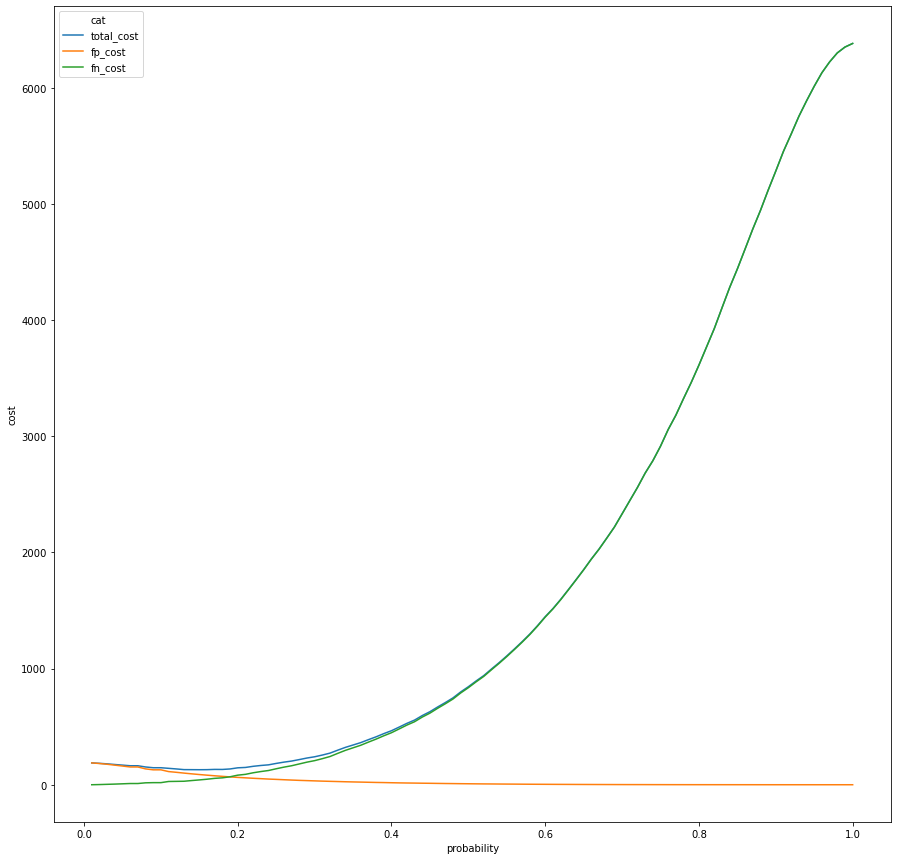

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.concat([
    pd.DataFrame({"cat":["total_cost"]*len(cost_df["total_cost"]),"probability":cost_df["probability"],"cost":cost_df["total_cost"]}),
    pd.DataFrame({"cat":["fp_cost"]*len(cost_df["fp_cost"]),"probability":cost_df["probability"],"cost":cost_df["fp_cost"]}),
    pd.DataFrame({"cat":["fn_cost"]*len(cost_df["fn_cost"]),"probability":cost_df["probability"],"cost":cost_df["fn_cost"]})
], axis=0)

df["cost"] = df.cost / 1000

fig, ax = plt.subplots(figsize=(15,15))
sns.lineplot(x="probability", y="cost", hue="cat", data=df, ax=ax)
plt.show()


# Appendix

In [1]:
import numpy as np
def reduce_features(df, verbose = False):
    # calculate the correlation matrix
    corr_matrix  = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
    #Get all of the correlation values > 95%
    x = np.where(upper > 0.95)

    #Display all field combinations with > 95% correlation
    cf = pd.DataFrame()
    cf['drop'] = upper.columns[x[1]]
    cf['keep'] = upper.index[x[0]]

    #Get the correlation values for every field combination. (There must be a more pythonic way to do this!)
    corr = [0] * len(cf)
    for i in range(0, len(cf)):
        corr[i] =  upper[cf['drop'][i]][cf['keep'][i]] 

    cf['Correlation'] = corr

    if( verbose ):
        print('There are ', str(len(cf['drop'])), ' field correlations > 95%.')
        display(cf)
        
        print('Dropping the following ', str(len(to_drop)), ' highly correlated fields.')
        to_drop
        
    #Check columns before drop 
    if( verbose ):
        print('\r\n*********Before: Dropping Highly Correlated Fields*************************************')
        display(df.info(verbose=False))

    # Drop the highly correlated features from our training data 
    df = df.drop(to_drop, axis=1)

    #Check columns after drop 
    if( verbose ):
        print('\r\n*********After: Dropping Highly Correlated Fields**************************************')
        df.info(verbose=False)
    
    return df